**ECG-Based Arrhythmias Anomaly Detection using Autoencoders**

ECG-Based Arrhythmias Anomaly Detection using Autoencoders An autoencoder is a type of neural network model that attempts to learn a compact representation of the input. Although they are an unsupervised learning method, they are technically trained using supervised learning methods, which are referred to as self-supervised. Typically, they are trained as part of a larger model that seeks to duplicate the input. The goal of an autoencoder is to train the network to capture the most important parts of the input image to learn a lower-dimensional representation for higher-dimensional data, typically for dimensionality reduction.

In [1]:
!pip install wfdb

In [2]:
import wfdb

In [3]:
pip install matplotlib==3.1.3

ERROR: Could not find a version that satisfies the requirement matplotlib==3.1.3 (from versions: none)
ERROR: No matching distribution found for matplotlib==3.1.3
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Importing Required Packages
import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import random
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import copy
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import precision_score,recall_score,accuracy_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import scipy.io
from scipy.io import savemat
# Random Initialization
random.seed(42)

# **Loading ECG Data**

In [5]:
import os
print(os.listdir("../input"))

['mitbih-normal-sinus-rhythm-database', 'mit-bih-arrhythmia-database']


# Abnormal ECG Data

The MIT-BIH Arrhythmia dataset (MIT-BIH-ARR) is mainly composed of 48 two-channel ambulatory ECG recordings sampled at 360Hz. Each recording lasts about 30 minutes. The data was gathered from 47 people. The participants were 25 men and 22 women, ranging in age from 32 to 89 years old. This dataset comprises recordings with various degrees of arrhythmias and also recordings with normal sinus rhythm. Professional reference annotations are included in each recording in the form of rhythm and beat annotations.

In [6]:
data= '../input/mit-bih-arrhythmia-database/'

In [7]:
# List of Patients
patients = ['100','101','102','103','104','105','106','107',
           '108','109','111','112','113','114','115','116',
           '117','118','119','121','122','123','124','200',
           '201','202','203','205','207','208','209','210',
           '212','213','214','215','217','219','220','221',
           '222','223','228','230','231','232','233','234']

In [8]:
# Creating a Empty Dataframe
dataframe = pd.DataFrame()

In [9]:
# Reading all .atr files 
for pts in patients:
    # Generating filepath for all .atr file names
    file = data + pts
    # Saving annotation object
    annotation = wfdb.rdann(file, 'atr')
    # Extracting symbols from the object
    sym = annotation.symbol
    # Saving value counts
    values, counts = np.unique(sym, return_counts=True)
    # Writing data points into dataframe
    df_sub = pd.DataFrame({'symbol':values, 'Counts':counts, 'Patient Number':[pts]*len(counts)})
    # Concatenating all data points  
    dataframe = pd.concat([dataframe, df_sub],axis = 0)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


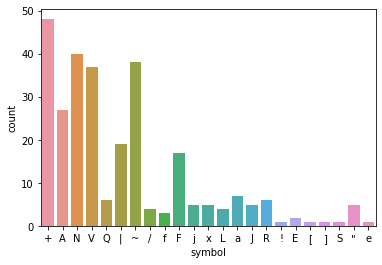

In [10]:
ax = sns.countplot(dataframe.symbol)

In [11]:
dataframe

,symbol,Counts,Patient Number
0,+,1,100
1,A,33,100
2,N,2239,100
3,V,1,100
0,+,1,101
...,...,...,...
0,+,3,234
1,J,50,234
2,N,2700,234
3,V,3,234


In [12]:
# Non Beat Symbols
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']

# Abnormal Beat Symbols
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

# Normal Beat Symbols
normal = ['N'] 
    

In [13]:
# Classifying normal, abnormal or nonbeat
dataframe['category'] = -1
dataframe.loc[dataframe.symbol == 'N','category'] = 0
dataframe.loc[dataframe.symbol.isin(abnormal), 'category'] = 1    
      
dataframe.groupby('category').Counts.sum()

category
-1     3186
 0    75052
 1    34409
Name: Counts, dtype: int64

In [14]:
#removing the non-beat from dataframe
dataframe = dataframe.loc[~((dataframe['category']==-1))]
dataframe.groupby('category').Counts.sum()

category
0    75052
1    34409
Name: Counts, dtype: int64

In [15]:
def load_ecg(file):    
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # extracting the signal
    p_signal = record.p_signal

    # extracting symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample
    

In [16]:
def build_XY(p_signal, df_ann, num_cols, normal):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_rows = len(df_ann)

    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []
    
    # keep track of rows
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in normal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X,Y,sym

In [17]:
# creating abnormal beat dataset
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    # input:
    #   pts - list of patients
    #   num_sec = number of seconds to include before and after the beat
    #   fs = frequency
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    # list to keep track of number of beats across patients
    max_rows = []
    
    for pt in pts:
        file = data + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
        
        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal)]
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, abnormal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
        
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]

    return X_all, Y_all, sym_all

In [18]:
# Parameter Values
num_sec = 1
fs = 360

X_abnormal, Y_abnormal, sym_abnormal = make_dataset(patients, num_sec, fs, abnormal)

## Normal ECG Data

In [19]:
data= '../input/mitbih-normal-sinus-rhythm-database/mit-bih-normal-sinus-rhythm-database-1.0.0/'

I chose two patients in order to have less computation time and less data.

In [20]:
patients = ["16265","16272"]

In [21]:
# creating normal beat dataset
def make_dataset(pts, num_sec, fs, normal):
    # function for making dataset ignoring non-beats
    # input:
    #   pts - list of patients
    #   num_sec = number of seconds to include before and after the beat
    #   fs = frequency
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    # list to keep track of number of beats across patients
    max_rows = []
    
    for pt in pts:
        file = data + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
        
        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(normal)]
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, normal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
        
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]

    return X_all, Y_all, sym_all

In [22]:
# Parameter Values
num_sec = 1
fs = 360

X_normal, Y_normal, sym_normal = make_dataset(patients, num_sec, fs, normal)

Too much normal sinus data so we should shrink the normal ECG data.

In [23]:
X_normal = X_normal[0:34376,:]

In [24]:
Y_normal = np.zeros((34376, 1))

We have abnormal and normal data and we are going to combine them together and transform these datasets into tensors then we will seperate these datasets into normal and anomaly train and test sets with the ratio 0.2.

In [25]:
X = np.append(X_normal,X_abnormal,axis=0)
Y = np.append(Y_normal,Y_abnormal,axis=0)
X = X[:,0:140]

In [26]:
raw_data= np.append(X, Y, axis=1)
raw_data = pd.DataFrame(raw_data)

# The last element contains the labels
labels = raw_data.iloc[: , -1]
labels= labels.values
# The other data points are the electrocadriogram data
data = raw_data.iloc[:, 0:-1]
data= data.values

Normalize the data to [0,1] using MinMaxScaler from the sklearn preprocessing module.

In [27]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
test_data = scaler.transform(test_data)
train_data = scaler.transform(train_data)


train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

In [28]:
normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

anomalous_train_data = train_data[train_labels]
anomalous_test_data = test_data[test_labels]

val_df, test_df = train_test_split(
  test_data,
  test_size=0.2, 
  random_state=42)

In [29]:
test_labels =  ~test_labels

Plot a normal ECG.

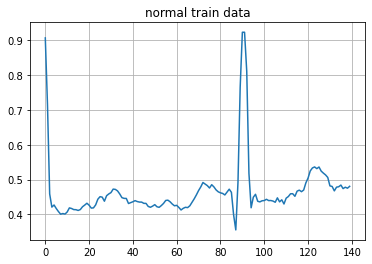

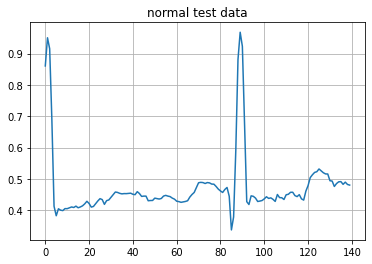

In [30]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("normal train data")
plt.show()

plt.grid()
plt.plot(np.arange(140), normal_test_data[543])
plt.title("normal test data")
plt.show()

Plot a abnormal ECG.

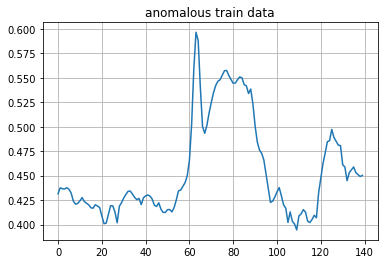

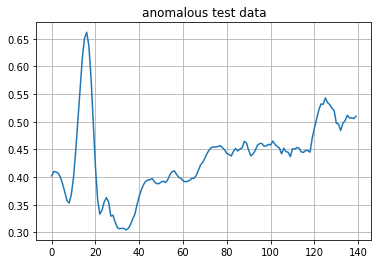

In [31]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("anomalous train data")
plt.show()

plt.grid()
plt.plot(np.arange(140), anomalous_test_data[0])
plt.title("anomalous test data")
plt.show()

#Build the model

For this project, we will utilize the Autoencoder model. There are two parts to the Autoencoder architecture in general. Autoencoder model consists of dense layers with different number of neurons. The input is compressed by an encoder, and the output is decoded by a decoder.

In [32]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
])
    self.decoder = tf.keras.Sequential([

      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

2022-02-17 17:07:11.827546: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [33]:
autoencoder.compile("adam", loss="mean_absolute_error")

Result at the 1500 epoch and 128 batch size, where the model achieve consistently strong results.

In [34]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=1500, 
          batch_size=128,
          validation_data=(normal_test_data, normal_test_data),
          shuffle=True)

2022-02-17 17:07:12.459685: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1500
216/216 [==============================] - 2s 6ms/step - loss: 0.0367 - val_loss: 0.0346
Epoch 2/1500
216/216 [==============================] - 1s 5ms/step - loss: 0.0343 - val_loss: 0.0342
Epoch 3/1500
216/216 [==============================] - 1s 5ms/step - loss: 0.0338 - val_loss: 0.0348
Epoch 4/1500
216/216 [==============================] - 1s 5ms/step - loss: 0.0332 - val_loss: 0.0331
Epoch 5/1500
216/216 [==============================] - 1s 5ms/step - loss: 0.0322 - val_loss: 0.0330
Epoch 6/1500
216/216 [==============================] - 1s 5ms/step - loss: 0.0314 - val_loss: 0.0307
Epoch 7/1500
216/216 [==============================] - 1s 5ms/step - loss: 0.0302 - val_loss: 0.0308
Epoch 8/1500
216/216 [==============================] - 1s 5ms/step - loss: 0.0292 - val_loss: 0.0292
Epoch 9/1500
216/216 [==============================] - 1s 6ms/step - loss: 0.0284 - val_loss: 0.0292
Epoch 10/1500
216/216 [==============================] - 1s 5ms/step - loss: 0.027

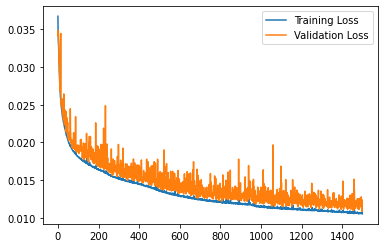

In [35]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

If the reconstruction error is larger than one standard deviation from normal training samples, we will shortly label an ECG as abnormal. Let's start with a normal ECG from the training set, then the reconstruction after the autoencoder has encoded and decoded it, also the reconstruction error.

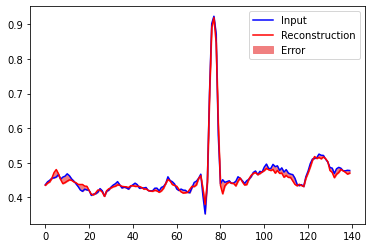

In [36]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

# Anomaly Detection

Calculate whether the reconstruction loss is larger than the defined threshold to detect abnormalities. In this section, you'll calculate the mean average error for normal cases in the training set, and then classify future examples as abnormal if the reconstruction error exceeds the training dataset's standard deviation. Plot the reconstruction error on the training set's normal ECGs.

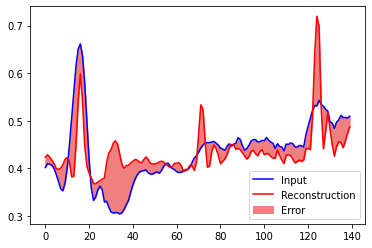

In [37]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

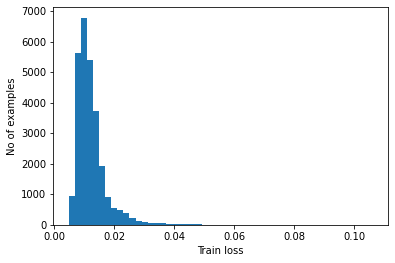

In [38]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [39]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.01765009385006706


When we look at the reconstruction error for the anomalous examples in the test set, we can see that the majority have a higher reconstruction error than the threshold. We may improve your classifier's precision and recall by adjusting the threshold.

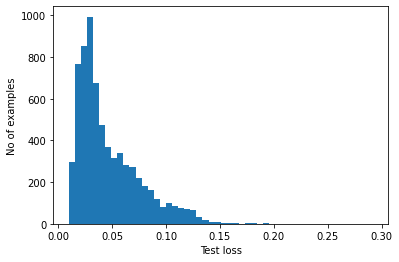

In [40]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [41]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))
#test_data = test_data. numpy()

In [42]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.8941167915060723
Precision = 0.898552864737153
Recall = 0.8878027429238401


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


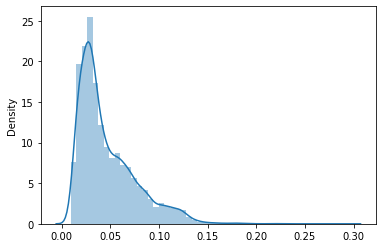

In [43]:
reconstructions = autoencoder.predict(anomalous_test_data)
train_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)
sns.distplot(train_loss, bins=50, kde=True);

Furthermore, we can count the number of examples that exceed the threshold (we will consider as anomalies)

In [44]:
reconstructions = autoencoder.predict(normal_test_data)
pred_loss = tf.keras.losses.mae(reconstructions, normal_test_data)

pred_loss = pred_loss.numpy()
correct = sum(l <= threshold for l in pred_loss)
print(f'Correct normal predictions: {correct}/{len(normal_test_data)}')

Correct normal predictions: 6085/6854


In [45]:
reconstructions = autoencoder.predict(anomalous_test_data)
train_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)
train_loss = train_loss.numpy()
correct = sum(l > threshold for l in train_loss)
print(f'Correct anomaly predictions: {correct}/{len(anomalous_test_data)}')

Correct anomaly predictions: 6210/6897


In [46]:
def plot_prediction_normal(i,data, model, title, ax):
    encoded_data = autoencoder.encoder(data).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    ax.axis([0, 140, 0, 1])
  
    ax.plot(data[i], label='true')
    ax.plot(decoded_data[i], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(1000*pred_loss[i], 2)})')
    ax.legend()

def plot_prediction_anomaly(i,data, model, title, ax):
    encoded_data = autoencoder.encoder(data).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    ax.axis([0, 140, 0, 1])
  
    ax.plot(data[i], label='true')
    ax.plot(decoded_data[i], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(1000*train_loss[i], 2)})')
    ax.legend()

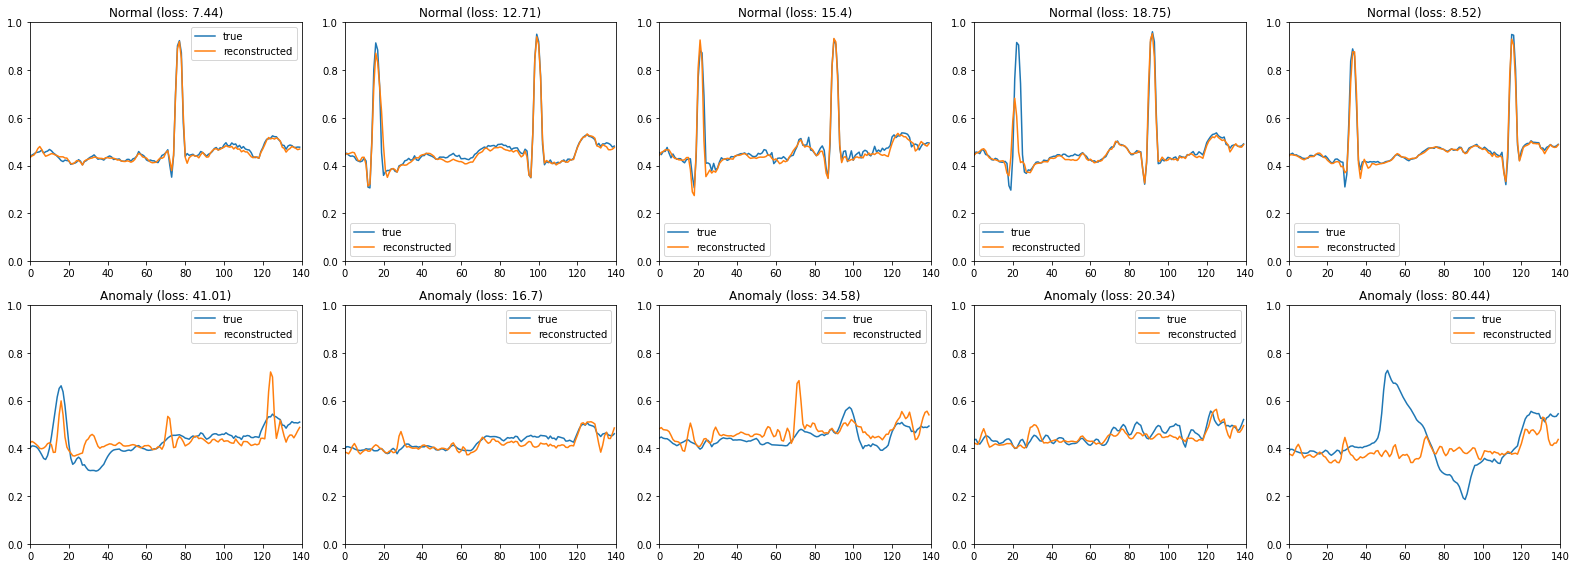

In [47]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=5,
  figsize=(22, 8)
)
for i in range(5) :
  plot_prediction_normal(i,normal_test_data, autoencoder, title='Normal', ax=axs[0, i])

for i in range(5) :
  plot_prediction_anomaly(i,anomalous_test_data, autoencoder, title='Anomaly', ax=axs[1, i])
fig.tight_layout();

This project provides the results of an unsupervised anomaly detection for ECG data  which is performed on MIT-BIH Arrhythmia Dataset and MIT-BIH Normal Sinus Rhythm Dataset. Although the findings are promising, there is certainly potential for improvement. Future projects might include: more complex model and different type of wavelet and more data to detect anomalies.